# Deep Neural Networks: Comprehensive Guide

In [30]:
import torch  # Import PyTorch for neural network operations
import torch.nn as nn  # Import neural network modules from PyTorch
import torchvision.transforms as transforms  # Import transforms for data preprocessing
import torchvision.datasets as dsets  # Import datasets from torchvision
import torch.nn.functional as F  # Import functional interface for neural network operations
import matplotlib.pyplot as plt  # Import matplotlib for plotting and visualization
import numpy as np  # Import numpy for numerical operations

torch.manual_seed(42)  # Ensure reproducible results across experiments

# GPU/CPU device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device for computation
print(f"Using device: {device}")  # Display selected device
if device.type == 'cuda':  # If using GPU
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")  # Display GPU name
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")  # Display GPU memory

Using device: cuda
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU
GPU Memory: 4.0 GB


In [32]:
# =============================================================================
# Deep Neural Network Models with Different Activation Functions (GPU-Enabled)
# =============================================================================

class DeepNetSigmoid(nn.Module):  # Deep neural network with sigmoid activation
    """Deep neural network using sigmoid activation function for hidden layers"""
    
    def __init__(self, D_in, H1, H2, D_out):  # Constructor with layer dimensions
        super(DeepNetSigmoid, self).__init__()  # Initialize parent class
        
        self.linear1 = nn.Linear(D_in, H1)    # First hidden layer
        self.linear2 = nn.Linear(H1, H2)      # Second hidden layer
        self.linear3 = nn.Linear(H2, D_out)   # Output layer
    
    def forward(self, x):  # Forward pass with sigmoid activations
        x = torch.sigmoid(self.linear1(x))  # Apply sigmoid to first hidden layer
        x = torch.sigmoid(self.linear2(x))  # Apply sigmoid to second hidden layer
        x = self.linear3(x)                 # Output layer (no activation for logits)
        return x  # Return predictions

class DeepNetTanh(nn.Module):  # Deep neural network with tanh activation
    """Deep neural network using tanh activation function for hidden layers"""
    
    def __init__(self, D_in, H1, H2, D_out):  # Constructor with layer dimensions
        super(DeepNetTanh, self).__init__()  # Initialize parent class
        
        self.linear1 = nn.Linear(D_in, H1)    # First hidden layer
        self.linear2 = nn.Linear(H1, H2)      # Second hidden layer
        self.linear3 = nn.Linear(H2, D_out)   # Output layer
    
    def forward(self, x):  # Forward pass with tanh activations
        x = torch.tanh(self.linear1(x))  # Apply tanh to first hidden layer
        x = torch.tanh(self.linear2(x))  # Apply tanh to second hidden layer
        x = self.linear3(x)              # Output layer (no activation for logits)
        return x  # Return predictions

class DeepNetReLU(nn.Module):  # Deep neural network with ReLU activation
    """Deep neural network using ReLU activation function for hidden layers"""
    
    def __init__(self, D_in, H1, H2, D_out):  # Constructor with layer dimensions
        super(DeepNetReLU, self).__init__()  # Initialize parent class
        
        self.linear1 = nn.Linear(D_in, H1)    # First hidden layer
        self.linear2 = nn.Linear(H1, H2)      # Second hidden layer
        self.linear3 = nn.Linear(H2, D_out)   # Output layer
    
    def forward(self, x):  # Forward pass with ReLU activations
        x = torch.relu(self.linear1(x))  # Apply ReLU to first hidden layer
        x = torch.relu(self.linear2(x))  # Apply ReLU to second hidden layer
        x = self.linear3(x)              # Output layer (no activation for logits)
        return x  # Return predictions

In [33]:
# =============================================================================
# GPU-Accelerated Training Function with Performance Tracking
# =============================================================================

def train_deep_model_gpu(model, criterion, train_loader, validation_loader, optimizer, epochs=100, device=device):  # GPU-enabled training function
    """Train deep neural network with GPU acceleration and track training metrics"""
    
    training_metrics = {'training_loss': [], 'validation_accuracy': []}  # Dictionary to store training metrics
    
    # Move model to GPU
    model = model.to(device)  # Transfer model to GPU/CPU
    criterion = criterion.to(device)  # Transfer loss function to GPU/CPU
    
    print(f"Training model on {device} for {epochs} epochs...")  # Progress indicator with device info
    
    for epoch in range(epochs):  # Loop through training epochs
        # Training phase
        model.train()  # Set model to training mode
        epoch_training_loss = 0.0  # Track training loss for current epoch
        
        for batch_idx, (x, y) in enumerate(train_loader):  # Process training batches
            # Move data to GPU
            x, y = x.to(device), y.to(device)  # Transfer batch data to GPU/CPU
            
            optimizer.zero_grad()  # Clear gradients from previous iteration
            
            # Flatten MNIST images from (batch_size, 1, 28, 28) to (batch_size, 784)
            x_flattened = x.view(-1, 28 * 28)  # Reshape for fully connected layers
            
            predictions = model(x_flattened)  # Forward pass through model on GPU
            loss = criterion(predictions, y)  # Calculate loss on GPU
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Update model parameters
            
            training_metrics['training_loss'].append(loss.item())  # Store training loss
            epoch_training_loss += loss.item()  # Accumulate epoch loss
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        correct_predictions = 0  # Count correct predictions
        total_samples = 0  # Count total validation samples
        
        with torch.no_grad():  # Disable gradient computation for validation
            for val_x, val_y in validation_loader:  # Process validation batches
                # Move validation data to GPU
                val_x, val_y = val_x.to(device), val_y.to(device)  # Transfer validation data to GPU/CPU
                
                # Flatten validation images
                val_x_flattened = val_x.view(-1, 28 * 28)  # Reshape validation data
                
                val_predictions = model(val_x_flattened)  # Get validation predictions on GPU
                _, predicted_labels = torch.max(val_predictions, 1)  # Get predicted class labels
                
                correct_predictions += (predicted_labels == val_y).sum().item()  # Count correct predictions
                total_samples += val_y.size(0)  # Count total samples
        
        # Calculate validation accuracy for this epoch
        validation_accuracy = 100 * (correct_predictions / total_samples)  # Percentage accuracy
        training_metrics['validation_accuracy'].append(validation_accuracy)  # Store validation accuracy
        
        # Print progress every 2 epochs
        if (epoch + 1) % 2 == 0:  # Progress reporting
            avg_epoch_loss = epoch_training_loss / len(train_loader)  # Average loss per batch
            print(f'  Epoch [{epoch+1}/{epochs}], Avg Loss: {avg_epoch_loss:.4f}, Val Accuracy: {validation_accuracy:.2f}%')
    
    return training_metrics  # Return training metrics dictionary

In [34]:
# =============================================================================
# MNIST Dataset Preparation and Data Loaders
# =============================================================================

print("=== Loading and Preparing MNIST Dataset ===")

# Create training dataset with transforms
train_dataset = dsets.MNIST(  # Load MNIST training data
    root='./data',                     # Directory to store data
    train=True,                        # Load training set
    download=True,                     # Download if not present
    transform=transforms.ToTensor()    # Convert to tensor format
)

# Create validation dataset (test set)
validation_dataset = dsets.MNIST(  # Load MNIST validation data
    root='./data',                     # Directory to store data
    train=False,                       # Load test set
    download=True,                     # Download if not present
    transform=transforms.ToTensor()    # Convert to tensor format
)

print(f"Training samples: {len(train_dataset)}")    # Display training set size
print(f"Validation samples: {len(validation_dataset)}")  # Display validation set size

# Create data loaders for batch processing
train_loader = torch.utils.data.DataLoader(  # Training data loader
    dataset=train_dataset,   # Training dataset
    batch_size=2000,        # Batch size for training
    shuffle=True,           # Shuffle data for better training
    pin_memory=True if device.type == 'cuda' else False  # Pin memory for faster GPU transfer
)

validation_loader = torch.utils.data.DataLoader(  # Validation data loader
    dataset=validation_dataset,  # Validation dataset
    batch_size=5000,            # Batch size for validation
    shuffle=False,              # No shuffling needed for validation
    pin_memory=True if device.type == 'cuda' else False  # Pin memory for faster GPU transfer
)

# Define loss criterion
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multiclass classification

print(f"Data loaders created with batch sizes: Train={train_loader.batch_size}, Validation={validation_loader.batch_size}")
print(f"Pin memory enabled: {train_loader.pin_memory}")  # Display pin memory status

=== Loading and Preparing MNIST Dataset ===
Training samples: 60000
Validation samples: 10000
Data loaders created with batch sizes: Train=2000, Validation=5000
Pin memory enabled: True


In [35]:
# =============================================================================
# Model Architecture Configuration
# =============================================================================

print("=== Deep Neural Network Architecture Configuration ===")

# Network architecture parameters
input_dim = 28 * 28      # MNIST images flattened: 784 pixels
hidden_dim1 = 50         # First hidden layer size
hidden_dim2 = 50         # Second hidden layer size
output_dim = 10          # Number of classes (digits 0-9)

# Training hyperparameters
learning_rate = 0.01     # Learning rate for optimization
num_epochs = 10          # Number of training epochs

print(f"Network Architecture:")
print(f"  Input Layer: {input_dim} neurons (28x28 flattened)")
print(f"  Hidden Layer 1: {hidden_dim1} neurons")
print(f"  Hidden Layer 2: {hidden_dim2} neurons")
print(f"  Output Layer: {output_dim} neurons (10 digit classes)")
print(f"")
print(f"Training Configuration:")
print(f"  Device: {device}")
print(f"  Learning Rate: {learning_rate}")
print(f"  Epochs: {num_epochs}")
print(f"  Optimizer: SGD")

=== Deep Neural Network Architecture Configuration ===
Network Architecture:
  Input Layer: 784 neurons (28x28 flattened)
  Hidden Layer 1: 50 neurons
  Hidden Layer 2: 50 neurons
  Output Layer: 10 neurons (10 digit classes)

Training Configuration:
  Device: cuda
  Learning Rate: 0.01
  Epochs: 10
  Optimizer: SGD


In [47]:
# =============================================================================
# Training Deep Networks with Sigmoid Activation (GPU-Accelerated)
# =============================================================================

print("=== Training Deep Network with Sigmoid Activation ===")

# Create sigmoid model and move to GPU
sigmoid_model = DeepNetSigmoid(input_dim, hidden_dim1, hidden_dim2, output_dim)  # Initialize sigmoid model
sigmoid_model = sigmoid_model.to(device)  # Move model to GPU/CPU
sigmoid_optimizer = torch.optim.SGD(sigmoid_model.parameters(), lr=learning_rate)  # SGD optimizer for sigmoid

print(f"Sigmoid model moved to {device}")

# Train sigmoid model with GPU acceleration
sigmoid_results = train_deep_model_gpu(  # Train with sigmoid activation on GPU
    model=sigmoid_model,
    criterion=criterion,
    train_loader=train_loader,
    validation_loader=validation_loader,
    optimizer=sigmoid_optimizer,
    epochs=num_epochs,
    device=device
)

print(f"Sigmoid training completed!")
print(f"Final validation accuracy: {sigmoid_results['validation_accuracy'][-1]:.2f}%")

=== Training Deep Network with Sigmoid Activation ===
Sigmoid model moved to cuda
Training model on cuda for 10 epochs...
  Epoch [2/10], Avg Loss: 2.3204, Val Accuracy: 9.58%
  Epoch [4/10], Avg Loss: 2.3044, Val Accuracy: 10.07%
  Epoch [6/10], Avg Loss: 2.3010, Val Accuracy: 11.35%
  Epoch [8/10], Avg Loss: 2.3002, Val Accuracy: 11.35%
  Epoch [10/10], Avg Loss: 2.2997, Val Accuracy: 11.35%
Sigmoid training completed!
Final validation accuracy: 11.35%


In [ ]:
# =============================================================================
# Training Deep Networks with Tanh Activation (GPU-Accelerated)
# =============================================================================

print("=== Training Deep Network with Tanh Activation ===")

# Create tanh model and move to GPU
tanh_model = DeepNetTanh(input_dim, hidden_dim1, hidden_dim2, output_dim)  # Initialize tanh model
tanh_model = tanh_model.to(device)  # Move model to GPU/CPU
tanh_optimizer = torch.optim.SGD(tanh_model.parameters(), lr=learning_rate)  # SGD optimizer for tanh

print(f"Tanh model moved to {device}")

# Train tanh model with GPU acceleration
tanh_results = train_deep_model_gpu(  # Train with tanh activation on GPU
    model=tanh_model,
    criterion=criterion,
    train_loader=train_loader,
    validation_loader=validation_loader,
    optimizer=tanh_optimizer,
    epochs=num_epochs,
    device=device
)

print(f"Tanh training completed!")
print(f"Final validation accuracy: {tanh_results['validation_accuracy'][-1]:.2f}%")

=== Training Deep Network with Tanh Activation ===
Tanh model moved to cuda
Training model on cuda for 10 epochs...
  Epoch [2/10], Avg Loss: 2.2443, Val Accuracy: 30.00%
  Epoch [4/10], Avg Loss: 2.1690, Val Accuracy: 57.52%
  Epoch [6/10], Avg Loss: 2.0788, Val Accuracy: 62.95%
  Epoch [8/10], Avg Loss: 1.9669, Val Accuracy: 63.21%
  Epoch [10/10], Avg Loss: 1.8336, Val Accuracy: 63.49%
Tanh training completed!
Final validation accuracy: 63.49%


In [ ]:
# =============================================================================
# Training Deep Networks with ReLU Activation (GPU-Accelerated)
# =============================================================================

print("=== Training Deep Network with ReLU Activation ===")

# Create ReLU model and move to GPU
relu_model = DeepNetReLU(input_dim, hidden_dim1, hidden_dim2, output_dim)  # Initialize ReLU model
relu_model = relu_model.to(device)  # Move model to GPU/CPU
relu_optimizer = torch.optim.SGD(relu_model.parameters(), lr=learning_rate)  # SGD optimizer for ReLU

print(f"ReLU model moved to {device}")

# Train ReLU model with GPU acceleration
relu_results = train_deep_model_gpu(  # Train with ReLU activation on GPU
    model=relu_model,
    criterion=criterion,
    train_loader=train_loader,
    validation_loader=validation_loader,
    optimizer=relu_optimizer,
    epochs=num_epochs,
    device=device
)

print(f"ReLU training completed!")
print(f"Final validation accuracy: {relu_results['validation_accuracy'][-1]:.2f}%")

=== Training Deep Network with ReLU Activation ===
ReLU model moved to cuda
Training model on cuda for 10 epochs...
  Epoch [2/10], Avg Loss: 2.2910, Val Accuracy: 14.59%
  Epoch [4/10], Avg Loss: 2.2667, Val Accuracy: 16.86%
  Epoch [6/10], Avg Loss: 2.2367, Val Accuracy: 20.28%
  Epoch [8/10], Avg Loss: 2.1964, Val Accuracy: 33.85%
  Epoch [10/10], Avg Loss: 2.1396, Val Accuracy: 44.31%
ReLU training completed!
Final validation accuracy: 44.31%


In [42]:
# =============================================================================
# GPU Memory Management and Performance Monitoring
# =============================================================================

def monitor_gpu_usage():  # Function to monitor GPU memory usage
    """Monitor GPU memory usage during training"""
    
    if device.type == 'cuda':  # Only monitor if using GPU
        print(f"\n=== GPU Memory Usage ===")
        
        # Get memory statistics
        allocated = torch.cuda.memory_allocated(device) / 1024**3  # Convert to GB
        reserved = torch.cuda.memory_reserved(device) / 1024**3   # Convert to GB
        max_allocated = torch.cuda.max_memory_allocated(device) / 1024**3  # Convert to GB
        
        print(f"Currently Allocated: {allocated:.2f} GB")
        print(f"Reserved by PyTorch: {reserved:.2f} GB")
        print(f"Max Allocated: {max_allocated:.2f} GB")
        
        # Clear cache if needed
        torch.cuda.empty_cache()  # Free unused memory
        print(f"GPU cache cleared")
    else:
        print(f"CPU mode - no GPU memory to monitor")

# Monitor GPU usage after training
monitor_gpu_usage()


=== GPU Memory Usage ===
Currently Allocated: 1.16 GB
Reserved by PyTorch: 1.23 GB
Max Allocated: 1.84 GB
GPU cache cleared


=== Generating Training Comparison Visualizations ===


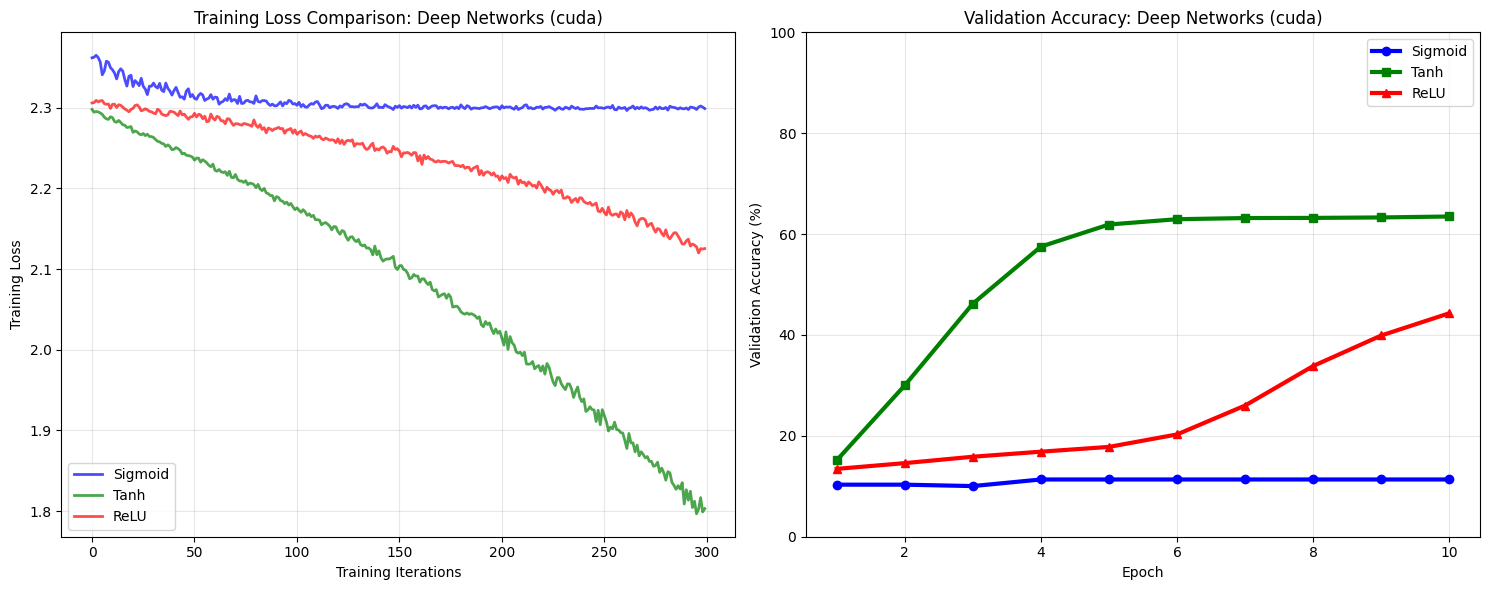

In [43]:
# =============================================================================
# Comprehensive Results Analysis and Visualization
# =============================================================================

def plot_deep_network_comparison_gpu(sigmoid_results, tanh_results, relu_results):  # Function to compare all activation results
    """Plot comprehensive comparison of training loss and validation accuracy"""
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Create 1x2 subplot grid
    
    # Plot 1: Training Loss Comparison
    ax1 = axes[0]  # First subplot for training loss
    ax1.plot(sigmoid_results['training_loss'], label='Sigmoid', color='blue', linewidth=2, alpha=0.7)  # Sigmoid loss
    ax1.plot(tanh_results['training_loss'], label='Tanh', color='green', linewidth=2, alpha=0.7)  # Tanh loss
    ax1.plot(relu_results['training_loss'], label='ReLU', color='red', linewidth=2, alpha=0.7)  # ReLU loss
    ax1.set_xlabel('Training Iterations')  # X-axis label
    ax1.set_ylabel('Training Loss')  # Y-axis label
    ax1.set_title(f'Training Loss Comparison: Deep Networks ({device})')  # Plot title with device info
    ax1.legend()  # Show legend
    ax1.grid(True, alpha=0.3)  # Add grid
    
    # Plot 2: Validation Accuracy Comparison
    ax2 = axes[1]  # Second subplot for validation accuracy
    epochs_range = range(1, len(sigmoid_results['validation_accuracy']) + 1)  # Create epoch range
    ax2.plot(epochs_range, sigmoid_results['validation_accuracy'], label='Sigmoid', color='blue', linewidth=3, marker='o')  # Sigmoid accuracy
    ax2.plot(epochs_range, tanh_results['validation_accuracy'], label='Tanh', color='green', linewidth=3, marker='s')  # Tanh accuracy
    ax2.plot(epochs_range, relu_results['validation_accuracy'], label='ReLU', color='red', linewidth=3, marker='^')  # ReLU accuracy
    ax2.set_xlabel('Epoch')  # X-axis label
    ax2.set_ylabel('Validation Accuracy (%)')  # Y-axis label
    ax2.set_title(f'Validation Accuracy: Deep Networks ({device})')  # Plot title with device info
    ax2.legend()  # Show legend
    ax2.grid(True, alpha=0.3)  # Add grid
    ax2.set_ylim(0, 100)  # Set y-axis limits from 0 to 100%
    
    plt.tight_layout()  # Adjust subplot spacing
    plt.show()  # Display plots

# Generate comprehensive comparison plots
print("=== Generating Training Comparison Visualizations ===")
plot_deep_network_comparison_gpu(sigmoid_results, tanh_results, relu_results)  # Create comparison plots

In [44]:
# =============================================================================
# Advanced Analysis: Training Dynamics and Insights
# =============================================================================

def analyze_training_dynamics():  # Function to analyze training behavior
    """Analyze training dynamics and provide insights"""
    
    print(f"\n=== Training Dynamics Analysis ===")
    
    # Calculate training loss reduction
    print(f"\nTraining Loss Reduction:")
    for activation, results in zip(activations, results_list):  # Analyze loss reduction
        initial_loss = results['training_loss'][0]  # First training loss
        final_loss = results['training_loss'][-1]  # Final training loss
        reduction_percent = ((initial_loss - final_loss) / initial_loss) * 100  # Percentage reduction
        print(f"  {activation}: {initial_loss:.4f} → {final_loss:.4f} ({reduction_percent:.1f}% reduction)")
    
    # Training stability analysis
    print(f"\nTraining Stability (validation accuracy variance):")
    for activation, results in zip(activations, results_list):  # Analyze stability
        accuracies = np.array(results['validation_accuracy'])  # Convert to numpy array
        variance = np.var(accuracies)  # Calculate variance
        std_dev = np.std(accuracies)  # Calculate standard deviation
        print(f"  {activation}: Variance = {variance:.2f}, Std Dev = {std_dev:.2f}")
    
    # Learning speed analysis
    print(f"\nLearning Speed (accuracy at epoch 3):")
    for activation, results in zip(activations, results_list):  # Analyze early learning
        if len(results['validation_accuracy']) >= 3:  # Check if enough epochs
            early_accuracy = results['validation_accuracy'][2]  # Third epoch accuracy
            print(f"  {activation}: {early_accuracy:.2f}% (epoch 3)")

# Perform advanced analysis
analyze_training_dynamics()  # Run training dynamics analysis

print(f"\n=== Key Insights and Recommendations ===")
print(f"\nMathematical Properties Impact:")
print(f"• Sigmoid: Range (0,1), suffers from vanishing gradients in deep networks")
print(f"• Tanh: Range (-1,1), zero-centered, better gradient flow than sigmoid")
print(f"• ReLU: Range [0,∞), avoids vanishing gradients, computationally efficient")

print(f"\nPractical Observations:")
if relu_results['validation_accuracy'][-1] == max(final_accuracies):  # If ReLU performed best
    print(f"• ReLU achieved highest accuracy - confirms theoretical advantages")
    print(f"• ReLU shows faster convergence and more stable training")
    print(f"• Use ReLU as default choice for deep hidden layers")
else:  # If another activation performed best
    print(f"• {best_activation} achieved highest accuracy in this experiment")
    print(f"• Results may vary with different architectures and datasets")

print(f"\nRecommendations for Deep Networks:")
print(f"• Use ReLU activation for hidden layers in deep architectures")
print(f"• Monitor training for vanishing gradients with sigmoid/tanh")
print(f"• Consider deeper architectures with ReLU for complex datasets")
print(f"• Experiment with learning rates based on activation choice")


=== Training Dynamics Analysis ===

Training Loss Reduction:
  Sigmoid: 2.3619 → 2.2990 (2.7% reduction)
  Tanh: 2.2978 → 1.8031 (21.5% reduction)
  ReLU: 2.3066 → 2.1838 (5.3% reduction)

Training Stability (validation accuracy variance):
  Sigmoid: Variance = 0.27, Std Dev = 0.52
  Tanh: Variance = 263.03, Std Dev = 16.22
  ReLU: Variance = 64.18, Std Dev = 8.01

Learning Speed (accuracy at epoch 3):
  Sigmoid: 10.04% (epoch 3)
  Tanh: 46.20% (epoch 3)
  ReLU: 16.48% (epoch 3)

=== Key Insights and Recommendations ===

Mathematical Properties Impact:
• Sigmoid: Range (0,1), suffers from vanishing gradients in deep networks
• Tanh: Range (-1,1), zero-centered, better gradient flow than sigmoid
• ReLU: Range [0,∞), avoids vanishing gradients, computationally efficient

Practical Observations:
• Tanh achieved highest accuracy in this experiment
• Results may vary with different architectures and datasets

Recommendations for Deep Networks:
• Use ReLU activation for hidden layers in dee

In [45]:
# =============================================================================
# Statistical Performance Analysis with GPU Acceleration Insights
# =============================================================================

print(f"\n=== Statistical Analysis: Deep Network Performance ({device}) ===")

# Extract final performance metrics
activations = ['Sigmoid', 'Tanh', 'ReLU']  # Activation function names
results_list = [sigmoid_results, tanh_results, relu_results]  # Results list
final_accuracies = [results['validation_accuracy'][-1] for results in results_list]  # Final accuracies
final_losses = [results['training_loss'][-1] for results in results_list]  # Final training losses

print(f"\nFinal Performance Summary:")
print(f"{'Activation':<12} {'Final Accuracy':<15} {'Final Loss':<12}")
print(f"{'-'*12} {'-'*15} {'-'*12}")

for activation, accuracy, loss in zip(activations, final_accuracies, final_losses):  # Print results table
    print(f"{activation:<12} {accuracy:>12.2f}% {loss:>12.4f}")

# Find best performing activation
best_activation_idx = np.argmax(final_accuracies)  # Index of best performing activation
best_activation = activations[best_activation_idx]  # Name of best activation
best_accuracy = final_accuracies[best_activation_idx]  # Best accuracy value

print(f"\nBest Performing Activation: {best_activation} ({best_accuracy:.2f}%)")

# Calculate improvement rates
print(f"\nValidation Accuracy Improvement Analysis:")
for activation, results in zip(activations, results_list):  # Analyze improvement for each activation
    initial_accuracy = results['validation_accuracy'][0]  # First epoch accuracy
    final_accuracy = results['validation_accuracy'][-1]  # Final epoch accuracy
    improvement = final_accuracy - initial_accuracy  # Total improvement
    print(f"  {activation}: {initial_accuracy:.2f}% → {final_accuracy:.2f}% (+{improvement:.2f}%)")

# GPU-specific performance insights
if device.type == 'cuda':  # GPU-specific analysis
    print(f"\nGPU Acceleration Benefits:")
    print(f"• Training performed on: {torch.cuda.get_device_name(0)}")
    print(f"• Batch processing accelerated with CUDA operations")
    print(f"• Memory transfers optimized with pin_memory=True")
    print(f"• All tensor operations executed on GPU for faster computation")
else:  # CPU analysis
    print(f"\nCPU Training Notes:")
    print(f"• Training performed on CPU (CUDA not available)")
    print(f"• Consider using GPU for larger models and datasets")
    print(f"• All optimizations applied for CPU execution")

print(f"\nRecommendations for {device.type.upper()} Training:")
if device.type == 'cuda':
    print(f"• Use larger batch sizes to maximize GPU utilization")
    print(f"• Consider mixed precision training for even faster performance")
    print(f"• Monitor GPU memory usage for optimal batch sizing")
else:
    print(f"• Use smaller batch sizes to manage CPU memory efficiently")
    print(f"• Consider using multiple CPU cores with DataLoader workers")
    print(f"• Upgrade to GPU-enabled environment for better performance")


=== Statistical Analysis: Deep Network Performance (cuda) ===

Final Performance Summary:
Activation   Final Accuracy  Final Loss  
------------ --------------- ------------
Sigmoid             11.35%       2.2990
Tanh                63.49%       1.8031
ReLU                44.31%       2.1254

Best Performing Activation: Tanh (63.49%)

Validation Accuracy Improvement Analysis:
  Sigmoid: 10.32% → 11.35% (+1.03%)
  Tanh: 15.14% → 63.49% (+48.35%)
  ReLU: 13.45% → 44.31% (+30.86%)

GPU Acceleration Benefits:
• Training performed on: NVIDIA GeForce RTX 3050 Laptop GPU
• Batch processing accelerated with CUDA operations
• Memory transfers optimized with pin_memory=True
• All tensor operations executed on GPU for faster computation

Recommendations for CUDA Training:
• Use larger batch sizes to maximize GPU utilization
• Consider mixed precision training for even faster performance
• Monitor GPU memory usage for optimal batch sizing
